In [29]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import datetime
import warnings 
import numpy as np
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pylab import rcParams
import statsmodels.api as sm
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
from tqdm import tqdm_notebook as tqdm




In [30]:
def difference(data, interval=1):
    diff = []
    for i in data:
        col_idx = i
    col = data[col_idx]
    curr = col[0]
    diff.append(0)
    for i in range(1, size):
        diff.append(col[i]-curr)
        curr = col[i]
    return diff

# extracting the ground truth
def meal_classification(differences, threshold):
    meal_bolus = []
    for d in differences:
        if d > threshold:
            meal_bolus.append('meal')
        else:
            meal_bolus.append('no meal')
            
    return meal_bolus

#get input data
cgm_data = pd.read_csv('CGMProcessed.csv')
bolus_data = pd.read_csv('BolusProcessed.csv')

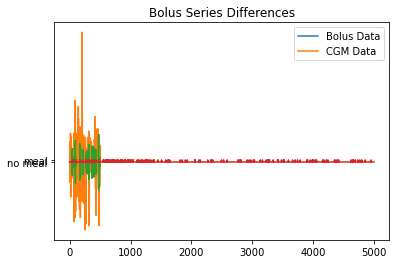

In [31]:
# preprocessed data
cgm_data.drop(['Unnamed: 0'],axis=1,inplace=True)
bolus_data.drop(['dateMuBolus'],axis=1,inplace=True)
bolus_data.drop(['Unnamed: 0'],axis=1,inplace=True)
size = len(bolus_data)

#get difference in bolus and cgm
bolus_diff = difference(bolus_data)
cgm_diff = difference(cgm_data)


plt.plot(bolus_diff[:500])
plt.plot(cgm_diff[:500])
plt.title('Bolus Series Differences v/s CGM Series Differences')
plt.legend(['Bolus Data', 'CGM Data'])
plt.plot(bolus_diff[:500])
plt.title('Bolus Series Differences')

threshold = 0.5
bolus_meal = meal_classification(bolus_diff, threshold)


plt.plot(bolus_meal[:5000])



In [32]:
#trim cgm to make bolus size match
start_cgm_data = cgm_data.iloc[:size]  

bolus_data['meal'] = bolus_meal
start_cgm_data['meal'] = bolus_meal
start_cgm_data['difference'] = cgm_diff
idxs = []
for i in range(len(bolus_meal)):
    if bolus_meal[i] is 'meal':
        idxs.append(i)


Text(0, 0.5, 'Amount-CGM')

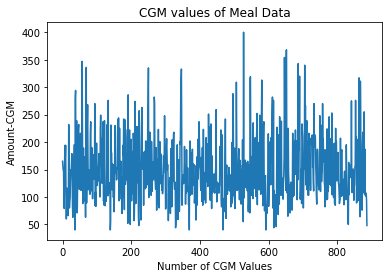

In [33]:
#get cgm for meal data
cgm = []
for i in idxs:
    cgm.append(start_cgm_data['numCGM'][i])

plt.plot(np.arange(0,887,1),cgm)
plt.title('CGM values of Meal Data')
plt.xlabel('Number of CGM Values')
plt.ylabel('Amount-CGM')




In [34]:
# assign labels for meal/no-meal

start_cgm_data['numCGM'] = start_cgm_data['numCGM'].astype(int)

for i in tqdm(range(len(start_cgm_data['meal']))):
    if start_cgm_data['meal'][i] == 'meal':
        start_cgm_data['meal'][i]=1
    else:
        start_cgm_data['meal'][i]=0

start_cgm_data

  0%|          | 0/41435 [00:00<?, ?it/s]

,dateNumber,numCGM,meal,difference
0,737103.557257,118,0,0.0
1,737103.553785,122,0,4.0
2,737103.539896,124,0,2.0
3,737103.536424,126,0,2.0
4,737103.532951,127,0,1.0
...,...,...,...,...
41430,736938.463773,300,0,7.0
41431,736938.460301,299,0,-1.0
41432,736938.456829,288,0,-11.0
41433,736938.453356,280,0,-8.0


In [35]:
# split into train and test sets

labels=np.array(start_cgm_data['meal'])
num_cgm=np.array(start_cgm_data['numCGM'])
num_cgm=np.array(num_cgm)
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(num_cgm, labels, test_size = 0.25, random_state = 42)
train_features=train_features.reshape(-1,1)
test_features=test_features.reshape(-1,1)
train_labels=train_labels.reshape(-1,1)
test_labels=test_labels.reshape(-1,1)

In [36]:
# use 100 decision trees, and train model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels);

In [37]:
# model prediction
predictions = rf.predict(test_features)
predictions


array([0.02553869, 0.01033311, 0.01963257, ..., 0.04109449, 0.0428668 ,
       0.02418434])

In [38]:
# error evaluation
errors = abs(predictions - test_labels)
errors

array([[0.025538688499265726, 0.01033310903749274, 0.019632566737493157,
        ..., 0.04109449053456779, 0.04286680249742573,
        0.024184335645611527],
       [0.025538688499265726, 0.01033310903749274, 0.019632566737493157,
        ..., 0.04109449053456779, 0.04286680249742573,
        0.024184335645611527],
       [0.025538688499265726, 0.01033310903749274, 0.019632566737493157,
        ..., 0.04109449053456779, 0.04286680249742573,
        0.024184335645611527],
       ...,
       [0.025538688499265726, 0.01033310903749274, 0.019632566737493157,
        ..., 0.04109449053456779, 0.04286680249742573,
        0.024184335645611527],
       [0.9744613115007342, 0.9896668909625073, 0.9803674332625069, ...,
        0.9589055094654322, 0.9571331975025743, 0.9758156643543885],
       [0.025538688499265726, 0.01033310903749274, 0.019632566737493157,
        ..., 0.04109449053456779, 0.04286680249742573,
        0.024184335645611527]], dtype=object)

In [39]:
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.04
